# Causal Inference Project

## Observing the relationship between mobile phone usage and car accidents

Now more than ever, it feels like there are more car crashes and traffic as a result than there used to be. Additionally, the continued development and reliance of smartphones has meant it's become much more common for drivers to be distracted by their smartphones. This short project intended to demonstrate proper use of causal inference methodology using various packages in Python, primarily Pandas, Sci-kit Learn and MatPlotLib. 

Data Sources
This analysis draws on publicly available data from the National Highway Traffic Safety Administration (NHTSA) and the Pew Research Center.

The NHTSA compiles monthly records of motor vehicle accidents in the United States, categorizing them as Fatal, Injury-causing, or Property-damaging. The dataset used in this analysis was obtained from: https://cdan.nhtsa.gov/query
.

The Pew Research Center conducts nationwide surveys on various aspects of society, including trends in cellphone and smartphone adoption. Their surveys, which began in 2002, initially tracked cellphone ownership. In 2011, they added a follow-up question to distinguish between standard cellphones and smartphones. The data referenced in this analysis was downloaded from: https://www.pewresearch.org/internet/fact-sheet/mobile/
.

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import io
%matplotlib inline 

In [9]:
crash_data = pd.read_csv("crash_by_month.csv") # crash data from NHTSA
phone_data = pd.read_csv("PEW_CellPhoneUsage.csv") # Usage data from the pew research center

### Data structure and characteristics

In [10]:
crash_data.head() # viewing the dataset

,year,January,February,March,April,May,June,July,August,September,October,November,December,Type,Population
0,2006,2931,2695,3042,3138,3345,3383,3527,3474,3348,3462,3168,3135,Fatal,299398484
1,2007,2732,2618,3092,3041,3312,3281,3460,3325,3235,3325,3066,2948,Fatal,301621157
2,2008,2575,2586,2549,2722,2887,3029,3018,3224,2860,3063,2829,2830,Fatal,304059724
3,2009,2377,2167,2349,2592,2780,2750,2787,2865,2650,2622,2512,2411,Fatal,307006550
4,2010,2101,1830,2213,2552,2704,2569,2852,2825,2799,2827,2587,2437,Fatal,309327143


In [11]:
crash_data.info() # finding out the size of the dataframe, data types and discovering missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        45 non-null     int64 
 1   January     45 non-null     int64 
 2   February    45 non-null     int64 
 3   March       45 non-null     int64 
 4   April       45 non-null     int64 
 5   May         45 non-null     int64 
 6   June        45 non-null     int64 
 7   July        45 non-null     int64 
 8   August      45 non-null     int64 
 9   September   45 non-null     int64 
 10  October     45 non-null     int64 
 11  November    45 non-null     int64 
 12  December    45 non-null     int64 
 13  Type        45 non-null     object
 14  Population  45 non-null     int64 
dtypes: int64(14), object(1)
memory usage: 5.4+ KB


The data consists of 15 columns and 45 rows. Mixed long and wide dataframe: year, type (of crash) and population are in long format. Number of crashes is in wide format with one column for each month. No missing data.



In [12]:
phone_data.head() # viewing top 5 rows of phone data

,Date,Cellphone,Smartphone
0,10/27/02,62,NaN
1,11/30/04,65,NaN
2,2/9/05,66,NaN
3,12/31/05,67,NaN
4,3/28/06,66,NaN


In [13]:
phone_data.info() # viewing phone dataframe, data types and missing data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        64 non-null     object 
 1   Cellphone   64 non-null     int64  
 2   Smartphone  29 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ KB


Phone data consists of 3 columns and 64 rows. Date column data type needs to be converted to a date. Cellphone and Smartphone columns are both percentages of the adult American population, no adjustments needed. Many missing data points in Smartphone.

### Data Formatting

#### Crash data

The data needs considerable formatting. Tasks include:
- Pivot from wide data frame to a long data frame
- Format the date column
- Sum the different types of crashes each month
- Normalize number of crashes to the population
- Add a column designating seasons of the year

In [15]:
long_crash_data = pd.melt(crash_data, id_vars=['year', 'Population', 'Type']) # Pivoting to long format
long_crash_data.rename(columns={ "variable" : "Month"}, inplace = True) # change column name months to "Month"
long_crash_data.head()

,year,Population,Type,Month,value
0,2006,299398484,Fatal,January,2931
1,2007,301621157,Fatal,January,2732
2,2008,304059724,Fatal,January,2575
3,2009,307006550,Fatal,January,2377
4,2010,309327143,Fatal,January,2101


In [16]:
long_crash_data["Month_Year"] = long_crash_data["Month"] + long_crash_data["year"].astype(str) # Concatenate month and year
long_crash_data["Date"] = pd.to_datetime(long_crash_data["Month_Year"]) # convert to date format
long_crash_data.drop(columns = ["year", "Month_Year"], inplace = True) # clean-up old columns

print(long_crash_data.head())
print(long_crash_data.info())

   Population   Type    Month  value       Date
0   299398484  Fatal  January   2931 2006-01-01
1   301621157  Fatal  January   2732 2007-01-01
2   304059724  Fatal  January   2575 2008-01-01
3   307006550  Fatal  January   2377 2009-01-01
4   309327143  Fatal  January   2101 2010-01-01
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Population  540 non-null    int64         
 1   Type        540 non-null    object        
 2   Month       540 non-null    object        
 3   value       540 non-null    int64         
 4   Date        540 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 21.2+ KB
None


In [19]:
summed_crash_data = long_crash_data.groupby(['Date', 'Population', 'Month'], as_index = False)["value"].sum() # sum types of crashes for each date
summed_crash_data.head()

,Date,Population,Month,value
0,2006-01-01,299398484,January,506512
1,2006-02-01,299398484,February,461160
2,2006-03-01,299398484,March,478828
3,2006-04-01,299398484,April,466287
4,2006-05-01,299398484,May,503526


In [21]:
summed_crash_data["Population_100k"] = summed_crash_data["Population"] / 100000 # population as number of 100s of thousands
summed_crash_data["Crashes_per_100k"] = summed_crash_data["value"] / summed_crash_data["Population_100k"] # normalize crash counts to per 100k people

summed_crash_data.drop(columns = ["Population", "value", "Population_100k"], inplace = True) # clean up columns

summed_crash_data.head()

,Date,Month,Crashes_per_100k
0,2006-01-01,January,169.176541
1,2006-02-01,February,154.028836
2,2006-03-01,March,159.930002
3,2006-04-01,April,155.741270
4,2006-05-01,May,168.179208


In [23]:
season_dict = {
    'December' : 'Winter',
    "January" :"Winter",
    "February" :"Winter",
    "March" :"Spring",
    "April": "Spring",
    "May" :"Spring",
    "June": "Summer",
    "July": "Summer",
    "August" :"Summer",
    "September" :"Fall",
    "October": "Fall",
    "November" :"Fall"
}

summed_crash_data["Season"] = summed_crash_data['Month'].map(season_dict) # create new column 'Season' using the month
summed_crash_data.drop(columns = ["Month"], inplace = True) # clean-up old columns

print(summed_crash_data.head())
print(summed_crash_data.info())

        Date  Crashes_per_100k  Season
0 2006-01-01        169.176541  Winter
1 2006-02-01        154.028836  Winter
2 2006-03-01        159.930002  Spring
3 2006-04-01        155.741270  Spring
4 2006-05-01        168.179208  Spring
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              180 non-null    datetime64[ns]
 1   Crashes_per_100k  180 non-null    float64       
 2   Season            180 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.3+ KB
None


In [24]:
phone_data['Date'] = pd.to_datetime(phone_data['Date']) # Formatting 'Date' column to datatime 

In [62]:
phone_data.tail()

,Date,Cellphone,Smartphone,date,Year
59,2016-05-03,92,70.0,2016-05-03,2016
60,2016-11-06,95,77.0,2016-11-06,2016
61,2018-01-10,95,77.0,2018-01-10,2018
62,2019-02-07,96,81.0,2019-02-07,2019
63,2021-02-08,97,85.0,2021-02-08,2021


## Merging datasets

#### In this section, I'll be merging the two datasets to explore the relationship between smartphone usage and crashes per 100k, looking only at the summed statistic in years, while keeping the scatteplot condensed, only starting the year from when the smartphone column isn't a null value.

In [51]:
phone_data['Date'] = pd.to_datetime(phone_data['Date'], format='%m/%d/%y')

# Create a 'Year' column from the 'Date'
phone_data['Year'] = phone_data['Date'].dt.year

# Convert 'Smartphone' column to numeric, coercing errors to 'Not a Number' (NaN)
phone_data['Smartphone'] = pd.to_numeric(phone_data['Smartphone'], errors='coerce')

# Group by 'Year' and calculate the average smartphone ownership for each year.
# .mean() is used in case a year has multiple data points.
phone_yearly = phone_data.groupby('Year')['Smartphone'].mean().reset_index()

print(phone_yearly.head())

   Year  Smartphone
0  2002         NaN
1  2004         NaN
2  2005         NaN
3  2006         NaN
4  2007         NaN


In [53]:
month_columns = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

crash_data['Total_Crashes'] = crash_data[month_columns].sum(axis=1) # Calculating total crashes for each row (each row is a year and a crash 'Type')

crash_yearly = crash_data.groupby('year')['Total_Crashes'].sum().reset_index() # Grouping by 'year' to sum the 'Total_Crashes' from all types (Fatal, Injury, etc.)

crash_yearly.rename(columns={'year': 'Year'}, inplace=True) # Renaming the 'year' column to 'Year' to prepare for the merge

print(crash_yearly.head()) # previewing data

merged_phone_crash = pd.merge(phone_yearly, crash_yearly, on='Year')

# Drop any rows that might have missing values (e.g., from early years with no smartphone data)
merged_phone_crash.dropna(inplace=True)

print("\n Final Merged Datase")
print(merged_phone_crash)

   Year  Total_Crashes
0  2006        5973213
1  2007        6024006
2  2008        5810845
3  2009        5505179
4  2010        5419444

 Final Merged Datase
    Year  Smartphone  Total_Crashes
5   2011   35.000000        5337827
6   2012   44.125000        5615047
7   2013   54.285714        5686891
8   2014   56.750000        6064285
9   2015   68.000000        6296134
10  2016   73.000000        6821129
11  2018   77.000000        6734682
12  2019   81.000000        6756085


## Plotting Data

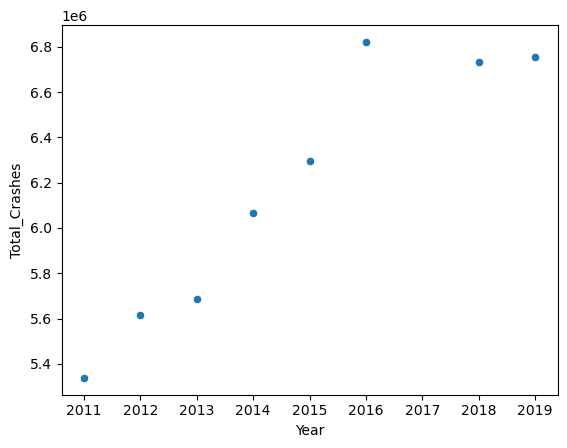

In [65]:
total_phone_crash = merged_phone_crash[(merged_phone_crash['Year'] <= 2022)] # filtering data

plt.figure()
sns.scatterplot(x = 'Year', y = 'Total_Crashes', data = total_phone_crash)

plt.show()

Above, I attempted to use a merged dataset to compare phone use and total crashes in each year, to see if there's any correlation between phone use and crashes in each year since the smartphones column didn't represent a null value. However due to the scattered data in both datasets, there wasn't enough datapoints to go off to produce an effective scattergraph, due to lack of datapoints.

Instead below I'll use a simple bar chart to display the data, as each datapoint represents multiple datapoints (month/day).

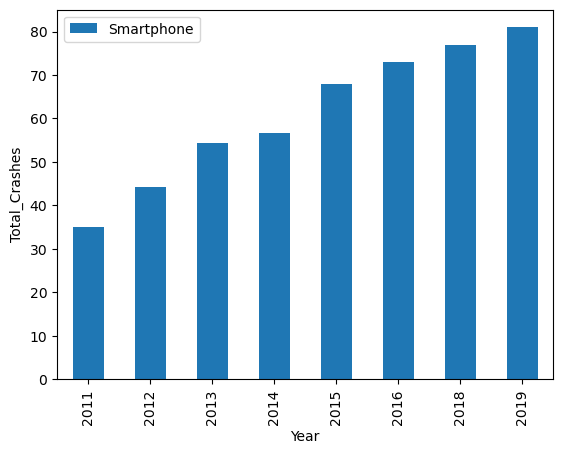

In [68]:
total_phone_crash.plot(x='Year', y='Smartphone', kind='bar')
plt.ylabel('Total_Crashes')
plt.show()

Above, the box plot shows that the steady increase in smartphone usage from 2011 has a clear effect on the amount of crashes in each year. Every year the smartphone usage statistic inreases, the crashes also increase.

The first iPhone was released in 2007, but did not become popular for a few years after its release. The first Android smartphone was released in 2008, and similarly experienced some lagtime before it gained popularity. However, 2011, with smartphone usage reaching 1/3 of the population and the recognition that the phenomenon is significant enough to record by the Pew Research Center, is a significant year. Therefore, 2011 will be used as the cutpoint in the ensuing causal inference analysis. As this is the key insight from this dataset, it does not need to be exported for further analysis with R.